In [1]:
suppressMessages(library(ArchR))
suppressMessages(library(dplyr))
suppressMessages(library(cowplot))
suppressMessages(library(Nebulosa))
suppressMessages(library(ggpubr))
suppressMessages(library(Ipaper))
suppressMessages(library(parallel))
suppressMessages(library(ggrepel))
suppressMessages(library(ComplexHeatmap))
suppressMessages(library(circlize))

In [2]:
df_gene <- read.csv("../data/snATAC_healthy_intermediate_damaged/gene_cluster.csv",
                   row.names = 1)
head(df_gene)

,gene,cluster
,<chr>,<chr>
1,LINC00486,damaged_CM
2,LARGE1,damaged_CM
3,PPP1R42,damaged_CM
4,TNRC18,damaged_CM
5,GYS1,damaged_CM
6,CHST3,damaged_CM


In [3]:
suppressMessages(library(gprofiler2))

In [4]:
df_go <- lapply(unique(df_gene$cluster), function(x){
    df_gene_sub <- subset(df_gene, cluster == x)
    
    gostres <- gost(query = df_gene_sub$gene,
                organism = "hsapiens",
               correction_method = "fdr",
               ordered_query = FALSE,
               significant = FALSE,
               measure_underrepresentation = FALSE)
    
    df <- gostres$result
    df$cluster <- x
    
    return(df)


}) %>% Reduce(rbind, .) %>%
    subset(., select = c("p_value", "source", "term_name", "cluster"))

In [5]:
head(df_go)

write.csv(df_go, "../data/snATAC_healthy_intermediate_damaged/GO_analysis.csv")

,p_value,source,term_name,cluster
,<dbl>,<chr>,<chr>,<chr>
1,0.003351129,CORUM,ITGA5-ITGB1-FN1-TGM2 complex,damaged_CM
2,0.028774992,CORUM,"Polycystin-1 multiprotein complex (ACTN1, CDH1, SRC, JUP, VCL, CTNNB1, PXN, BCAR1, PKD1, PTK2, TLN1)",damaged_CM
3,0.078132051,CORUM,ITGA1-ITGB1-COL6A3 complex,damaged_CM
4,0.078132051,CORUM,ITGA4-ITGB1-THBS1 complex,damaged_CM
5,0.078132051,CORUM,ITGA5-ITGB1-ADAM15 complex,damaged_CM
6,0.078132051,CORUM,ITGA5-ITGB4 complex,damaged_CM


In [6]:
unique(df_go$source)

[1] "CORUM" "GO:BP" "GO:CC" "GO:MF" "HP"    "HPA"   "KEGG"  "MIRNA" "REAC" 
[10] "TF"    "WP"

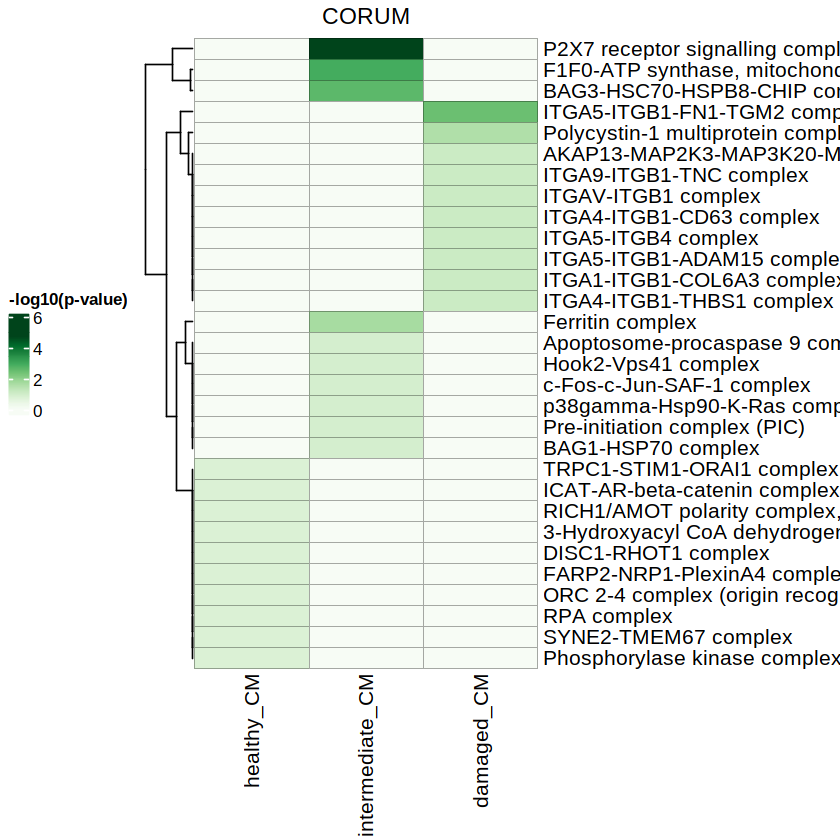

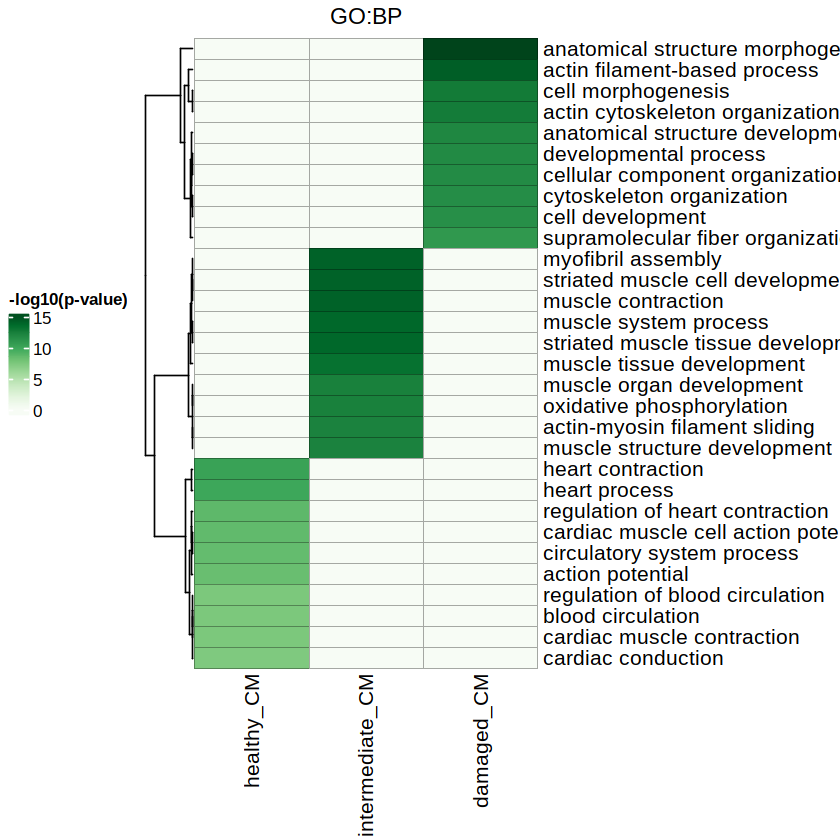

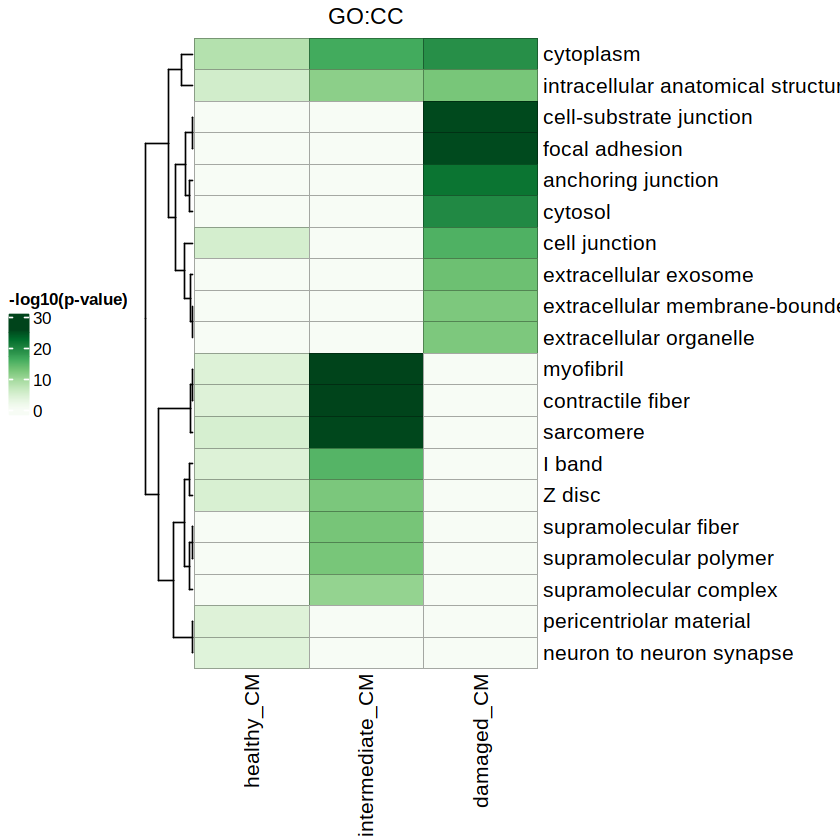

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'colon; endothelial cells[≥Low]' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'colon; endothelial cells[≥Low]' in 'mbcsToSbcs': dot substituted for <89>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'colon; endothelial cells[≥Low]' in 'mbcsToSbcs': dot substituted for <a5>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'smooth muscle; smooth muscle cells[≥Low]' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'smooth muscle; smooth muscle cells[≥Low]' in 'mbcsToSbcs': dot substituted for <89>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, 

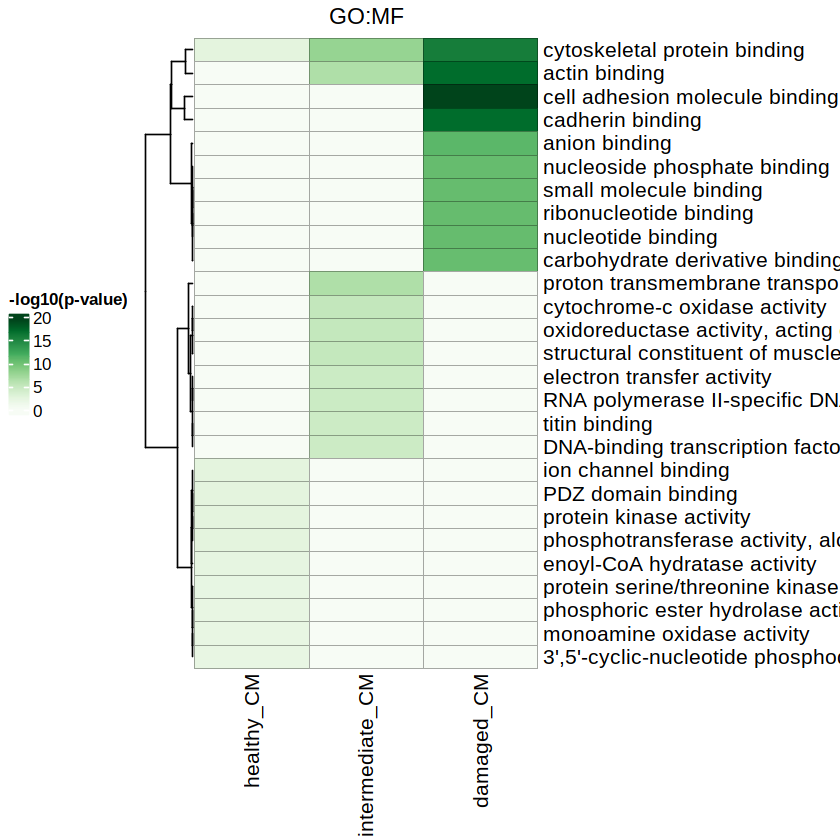

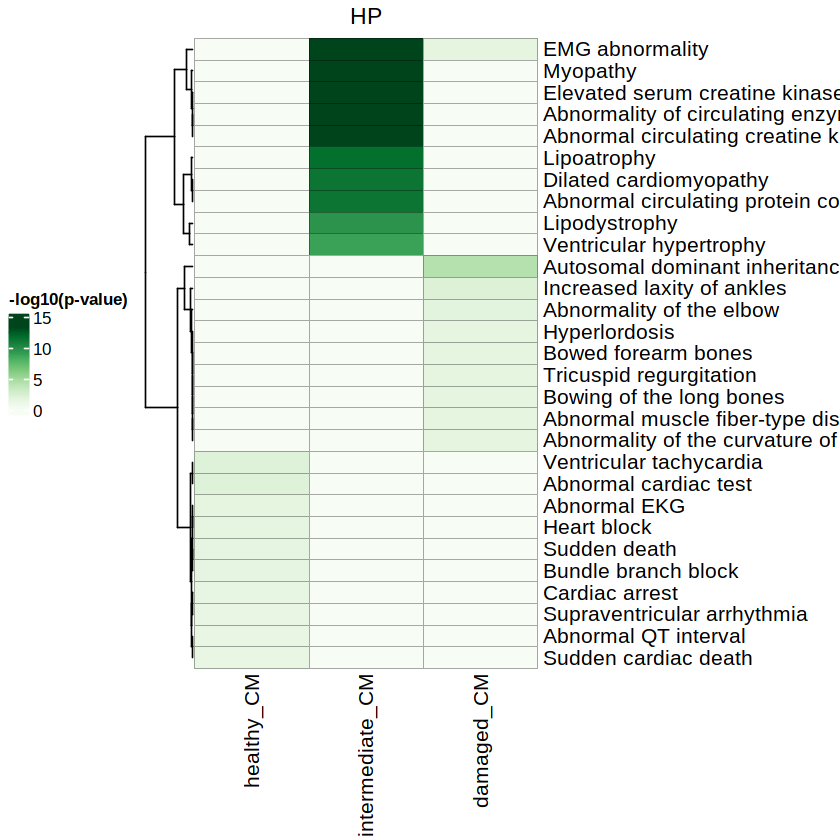

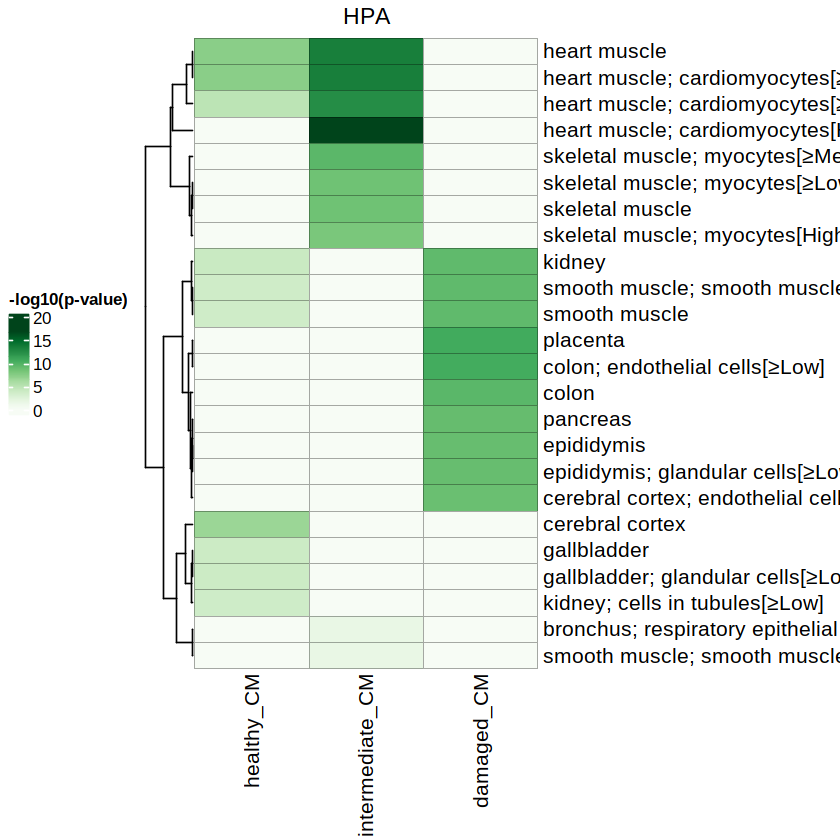

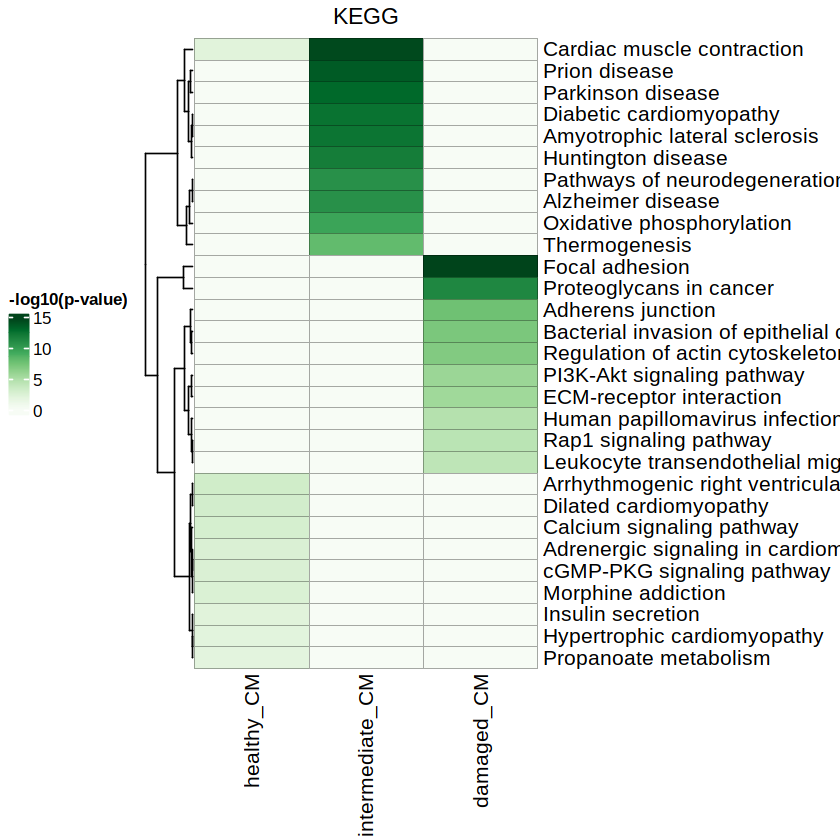

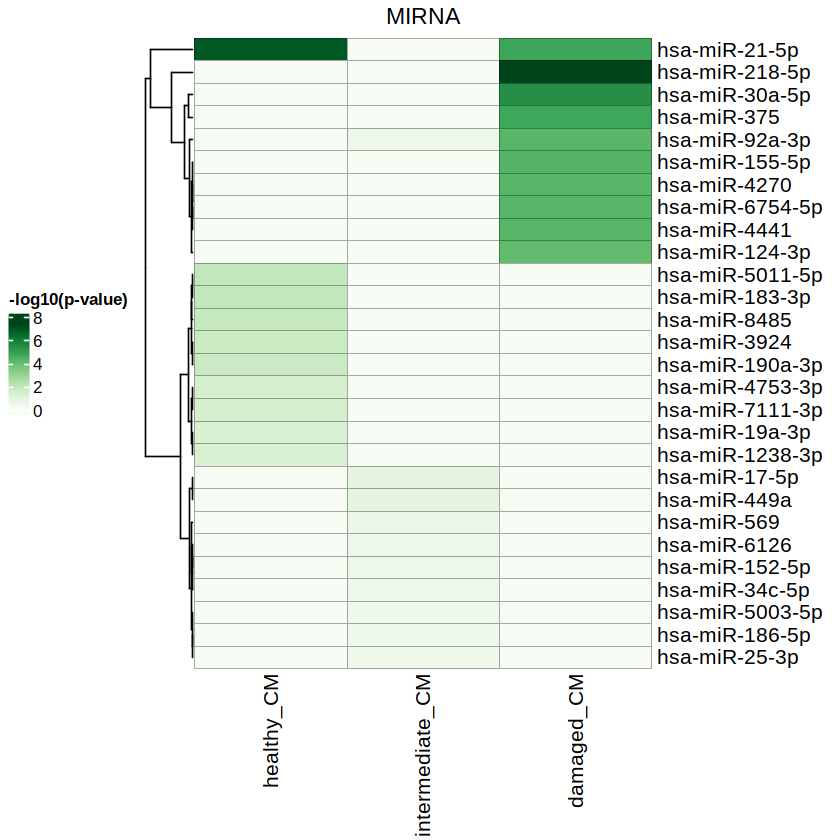

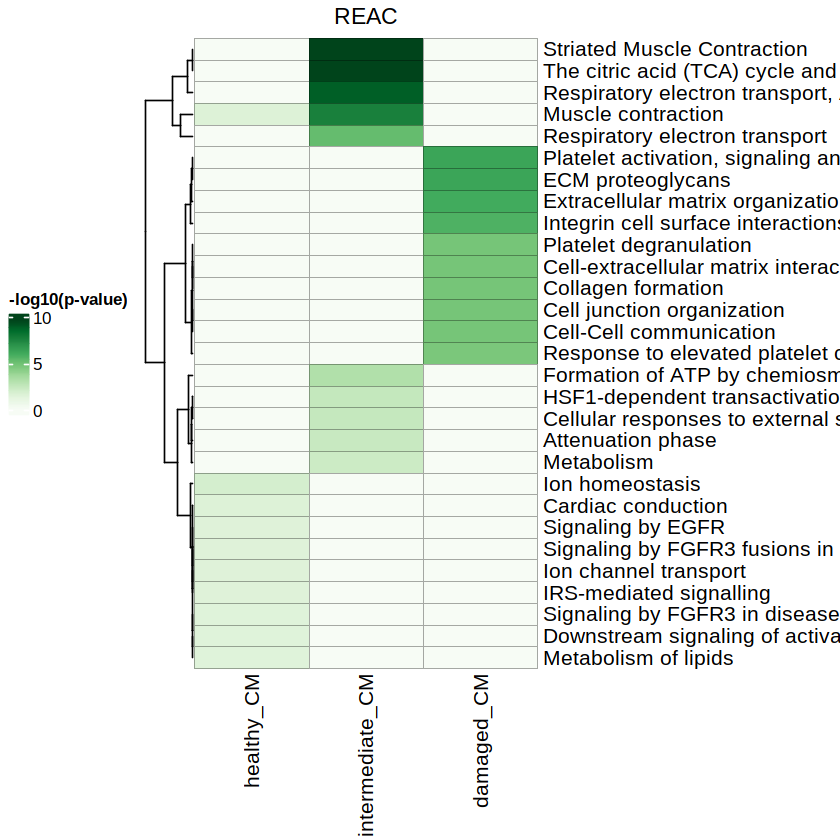

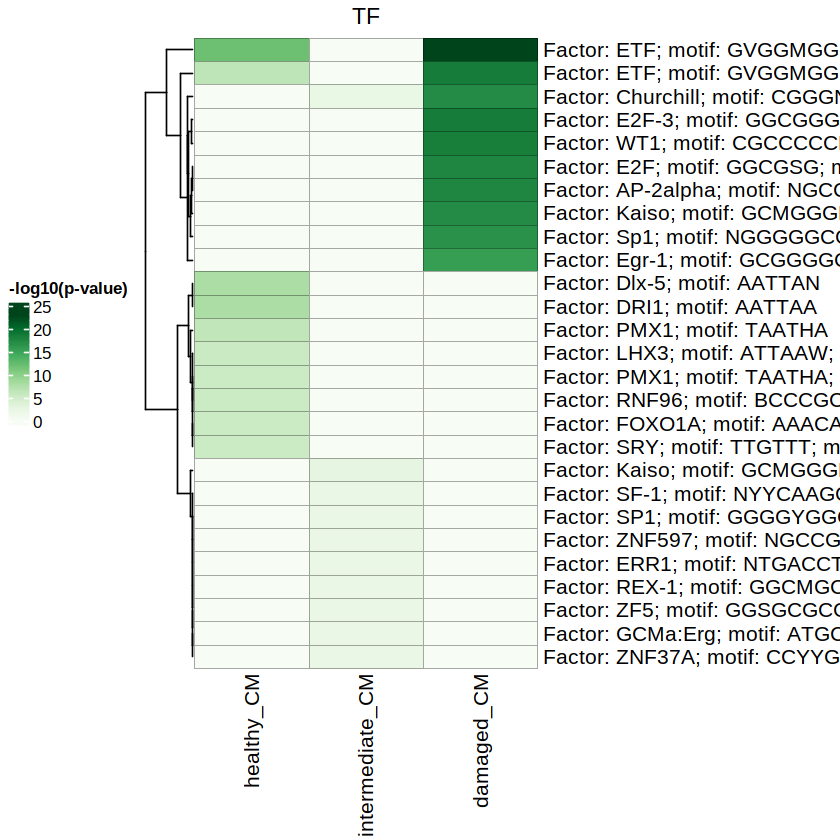

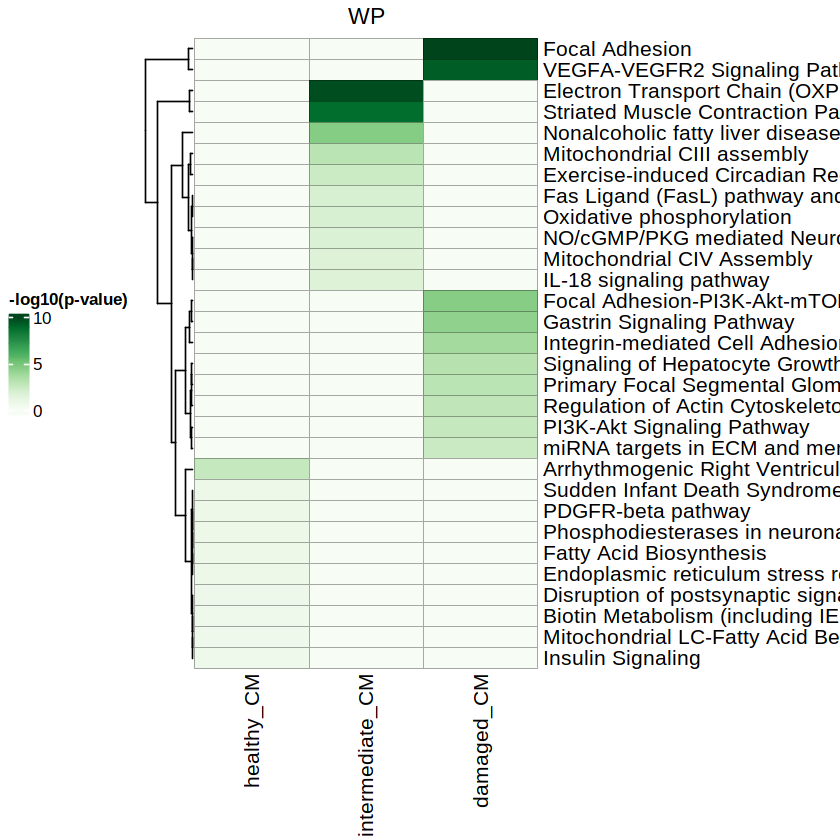

In [7]:
for(s in unique(df_go$source)){
    df_go_sub <- df_go %>%
            subset(source == s) %>%
            mutate(p_value = -log10(p_value)) %>%
            dplyr::select(-source) %>%
            group_by(cluster) %>%
            slice_max(n = 10, order_by = p_value, with_ties = FALSE) %>%
            tidyr::pivot_wider(names_from = cluster, values_from = p_value, values_fill = 0) %>%
            textshape::column_to_rownames("term_name")
    
    df_go_sub <- df_go_sub[, c("healthy_CM", "intermediate_CM", "damaged_CM")]
    
    col_fun <- colorRamp2(seq(from = min(df_go_sub), to = max(df_go_sub)*0.95, length = 9), 
                     RColorBrewer::brewer.pal(name = "Greens", n = 9))

    ht <- Heatmap(as.matrix(df_go_sub),
                  name = "-log10(p-value)",
    #            show_row_names = FALSE,
                  cluster_columns = FALSE,
                  clustering_distance_columns = "pearson",
                  clustering_method_columns = "ward.D2",
                  col = col_fun,
                  rect_gp = gpar(col = "black", lwd = 0.2),
                  column_title = s
                 )

    draw(ht,  heatmap_legend_side = "left")

}